In [1]:
# modules to import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
# this to set the plot styles 
sns.set_context('paper', font_scale = 1.5, rc = {"lines.linewidth": 1.5})
sns.set_style('ticks', {'axes.grid': False, 
                        'grid.linestyle': '', 
                        'font.family':'sans-serif', 
                        'font.sans-serif':'Myriad Pro',
                        'text.color': '0',
                        'xtick.color': '0',
                        'ytick.color': '0'
                           })

from Bio import Seq, SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx
from itertools import islice
import re
import random

# import sklearn modules 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# load in the toehold dataset and preprocess for ML 
df = pd.read_csv('/home/pradeep/Documents/TPOT/data/newQC_toehold_data.csv', comment = '#')

# rename the columns 
rename_dict = {
    "Unnamed: 0" : "toehold_id",
    "onoff_value" : "delta_onoff",
    "onoff_qc" : "delta_qc_onoff",
    "switch_sequence" : "min_toehold_sequence"
}

# clean up df to get rid of NaN and low qc reads 
df = df.rename(columns = rename_dict)
df = df.dropna() # throw out nan's 

ngs_qc_onind = df['on_qc'] >= 1.1 # keep all the acceptable reads for the ON
ngs_qc_offind = df['off_qc'] >= 1.1 # keep all the acceptable reads for the OFF
df = df.loc[ngs_qc_onind & ngs_qc_offind, :]

# bin the toeholds by their ON/OFF ratio into quartlies  
df['toehold_quartile'] = pd.qcut(df['delta_onoff'], q = 4, labels = ['worst', 'q2', 'q3', 'best'])

# slice out the top 25% and bottom 75%
df_top = df[df['toehold_quartile'] == 'best']

df_bottom = df[df['toehold_quartile'] != 'best']
df_bottom['toehold_quartile'] = 'worst'

df_classify = pd.concat([df_top, df_bottom], axis = 0)

# instantiate the label encoder
label_encoder = LabelEncoder()
df_classify['quartile_rating'] = label_encoder.fit_transform(df_classify['toehold_quartile'])
df_classify = df_classify.sample(frac = 1)
df_classify.head()

,off_id,on_id,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,...,post_linker,on_value,off_value,delta_onoff,on_qc,off_qc,delta_qc_onoff,min_toehold_sequence,toehold_quartile,quartile_rating
224132,AACCAAACACACAAACGCACTGTTCAGGATGTGTGGAACATATGCC...,CTTAGGCATATGTTCCACACATCCTGAACAAACCAAACACACAAAC...,smallpox,smallpox_tile_1001,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,CTTAGGCATATGTTCCACACATCCTGAACA,AACCAAACACACAAACGCAC,TGTTCAGGATGTGTGGAACATATGCCTAAG,AACAGAGGAGA,...,TAAAGGAGAA,0.375483,0.205203,0.170279,3.0,3.0,3.0,TGTTCAGGATGTGTGGAACATATGCCTAAGAACAGAGGAGACTTAG...,worst,1
189052,AACCAAACACACAAACGCACTCAAACACTTCTTCTTCTGACATCAG...,TGTCCTGATGTCAGAAGAAGAAGTGTTTGAAACCAAACACACAAAC...,human_KDM5A,human_KDM5A_tile_198,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TGTCCTGATGTCAGAAGAAGAAGTGTTTGA,AACCAAACACACAAACGCAC,TCAAACACTTCTTCTTCTGACATCAGGACA,AACAGAGGAGA,...,TAAAGGAGAA,0.513165,0.036914,0.476251,2.0,4.0,2.0,TCAAACACTTCTTCTTCTGACATCAGGACAAACAGAGGAGATGTCC...,best,0
144630,AACCAAACACACAAACGCACGCTTGCTCTGCTCCTCCAGGAGGGCA...,ACCATGCCCTCCTGGAGGAGCAGAGCAAGCAACCAAACACACAAAC...,human_ACTN4,human_ACTN4_tile_191,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACCATGCCCTCCTGGAGGAGCAGAGCAAGC,AACCAAACACACAAACGCAC,GCTTGCTCTGCTCCTCCAGGAGGGCATGGT,AACAGAGGAGA,...,TAAAGGAGAA,0.283766,0.038912,0.244854,3.0,1.1,1.1,GCTTGCTCTGCTCCTCCAGGAGGGCATGGTAACAGAGGAGAACCAT...,worst,1
29708,AACCAAACACACAAACGCACAGCCATTGCAAGCATGATAATGTATT...,ACTAAATACATTATCATGCTTGCAATGGCTAACCAAACACACAAAC...,smallpox,smallpox_tile_21957,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACTAAATACATTATCATGCTTGCAATGGCT,AACCAAACACACAAACGCAC,AGCCATTGCAAGCATGATAATGTATTTAGT,AACAGAGGAGA,...,TAAAGGAGAA,0.934852,0.333333,0.601519,3.0,1.1,1.1,AGCCATTGCAAGCATGATAATGTATTTAGTAACAGAGGAGAACTAA...,best,0
200746,AACCAAACACACAAACGCACTCTACAGTGTGATGCATCCAACCTAA...,ACAGTTAGGTTGGATGCATCACACTGTAGAAACCAAACACACAAAC...,human_KDM6A,human_KDM6A_tile_75,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACAGTTAGGTTGGATGCATCACACTGTAGA,AACCAAACACACAAACGCAC,TCTACAGTGTGATGCATCCAACCTAACTGT,AACAGAGGAGA,...,TAAAGGAGAA,1.000000,0.750731,0.249269,1.1,3.0,1.1,TCTACAGTGTGATGCATCCAACCTAACTGTAACAGAGGAGAACAGT...,worst,1


In [3]:
# define functions to tokenize DNA and produce a 'sentence' of k-mer tokens 
def tokenize_dna(seq, ngram_size, ngram_stride):
    """
    Function to break up a DNA sequence into kmers
    
    Inputs:
    seq: str
    ngram_size: int
    ngram_stride: int
    """
    if ngram_size == 1:
        toks = list(seq) # for character level encoding of a dna sequence
    else:
        toks = [seq[i:i+ngram_size] for i in range(0, len(seq), ngram_stride)]
    return toks

# stitch the tokens together into a sentence 
def seq_sentence(seq, ngram_size, ngram_stride):
    """
    Function that stitches together DNA kmers into a sentence
    
    Inputs:
    seq: str
    ngram_size: int
    ngram_stride: int
    """
    toks = tokenize_dna(seq = seq, ngram_size = ngram_size, ngram_stride = ngram_stride)
    seq_sentence = ' '.join(toks)
    
    return seq_sentence

def seq_scrambler(seq):
    """ 
    Return the scrambled sequence of an input sequence. Ensures that the scrambled output returned has the same letter frequency
    but in a different order than the original sequence. Negative control for all models.
        
    Inputs:
    seq: str
    """
    scrambled_sequence = seq

    if len(set(seq)) == 1:
        return scrambled_sequence
    else:
        while scrambled_sequence == seq:
            chars = list(seq)
            random.shuffle(chars)
            scrambled_sequence = ''.join(chars)
    return scrambled_sequence


In [4]:
# unit test to show that seq scrambler works as desired
test = df_classify['min_toehold_sequence'].iloc[0]
print('original sequence:', test)
s = seq_scrambler(test)
print('scrambled original sequence:', s)

original sequence: TGTTCAGGATGTGTGGAACATATGCCTAAGAACAGAGGAGACTTAGGATGATGTTCCAC
scrambled original sequence: GGTTGTCGGTGGGAAGGTACAACATAGAAAGTCATCACAATTCAATTGGTGTCGGCAAT


In [5]:
# function to simulate many trials of a sklearn model
def simulate_sklearn_model(df_classify, ngram_size, ngram_stride, model, model_params, num_trials = 5):
    """
    Function to simulate a scikit-learn Tf-idf classifier.
    
    Inputs:
    df_classify: df that contains a column called 'min_toehold_sequence' and 'quartile_rating'
                'min_toehold_sequence': str which is the minimal toehold sequence of length 59 nt
                'quartile_rating': integer encoded label to classify the top25% vs. the bottom 75%
    ngram_size: int
    ngram_stride: int
    model: scikit-learn model object
    model_params: dict - model_params to run a grid-search 
    num_trials: int - number of times to repeat the process
    """
    # convert the toehold sequence into a sentence of kmers 
    df_classify['toehold_sentence'] = df_classify['min_toehold_sequence'].apply(lambda p: seq_sentence(seq=p, ngram_size=ngram_size, ngram_stride=ngram_stride))
    # get a list of all toeholds
    toeholds = df_classify['min_toehold_sequence'].values.tolist()
    # scramble these sequences 
    scr_toes = [seq_scrambler(seq = p) for p in toeholds]
    # turn these scrambled seqs into sentences 
    scr_toes_sent = [seq_sentence(seq=p, ngram_size=ngram_size, ngram_stride=ngram_stride) for p in scr_toes]
    df_classify['scrambled_sentence'] = scr_toes_sent
    
    # define the training and testing arrays
    X = df_classify['toehold_sentence']
    X_control = df_classify['scrambled_sentence']
    y = df_classify['quartile_rating']
    
    skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
    scoring_dict = {'MCC': make_scorer(mcc, greater_is_better = True)}
    # create empty lists for the metrics to be saved
    mccs = []
    accs = []
    aucs = []
    
    mccs_control = []
    accs_control = []
    aucs_control = []
    ngram_sizes = []
    ngram_strides = []
    
    for trial in range(num_trials):
        
        # split into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, stratify = y)
        
        # tf-idf transform the training set, considering unigrams and bigrams only
        tfidf_vec = TfidfVectorizer(lowercase = False, ngram_range = (1,2), analyzer = 'word')
        x_train_idf = tfidf_vec.fit_transform(x_train)
        # transform the test set similarly
        x_test_idf = tfidf_vec.transform(x_test)
        # transform the control set similarly
        x_control_idf = tfidf_vec.transform(X_control)
        
        clf = GridSearchCV(model, param_grid = model_params, scoring = scoring_dict, n_jobs = -1, cv = skf, refit = 'MCC',
                       return_train_score = False)
        clf.fit(x_train_idf, y_train)
        clf_best = clf.best_estimator_
    
        # evaluate on test and control sets
        accs.append(clf_best.score(x_test_idf, y_test)) 
        accs_control.append(clf_best.score(x_control_idf, y))
        
        y_pred = clf_best.predict(x_test_idf)
        y_pred_cont = clf_best.predict(x_control_idf)
        
        mccs.append(mcc(y_test, y_pred))
        mccs_control.append(mcc(y, y_pred_cont))
        
        y_proba = clf_best.predict_proba(x_test_idf)
        y_cont_proba = clf_best.predict_proba(x_control_idf)
        
        aucs.append(roc_auc_score(y_test, y_proba[:,1]))
        aucs_control.append(roc_auc_score(y, y_cont_proba[:,1]))
        
        ngram_sizes.append(ngram_size)
        ngram_strides.append(ngram_stride)

    df_eval = pd.DataFrame()
    df_eval['test accuracy'] = accs
    df_eval['test roc_auc'] = aucs
    df_eval['test mcc'] = mccs
    df_eval['scrambled accuracy'] = accs_control
    df_eval['scrambled roc_auc'] = aucs_control
    df_eval['scrambled mcc'] = mccs_control
    df_eval['ngram_size'] = ngram_sizes
    df_eval['ngram_strides'] = ngram_strides
    
    return df_eval, clf_best

def get_model_lc(df_classify, model, ngram_size, ngram_stride, title):
    """
    Function that plots the learning curve for a scikit-learn tf-idf model.
    
    df_classify: df that contains a column called 'min_toehold_sequence' and 'quartile_rating'
                'min_toehold_sequence': str which is the minimal toehold sequence of length 59 nt
                'quartile_rating': integer encoded label to classify the top25% vs. the bottom 75%
    ngram_size: int
    ngram_stride: int
    model: pre-trained scikit-learn model object
    title: str - model name

    """
    
    skf = StratifiedKFold(n_splits = 10, shuffle = False)
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # convert the toehold sequence into a sentence of kmers 
    df_classify['toehold_sentence'] = df_classify['min_toehold_sequence'].apply(lambda p: seq_sentence(seq=p, ngram_size=ngram_size, ngram_stride=ngram_stride))
    # get a list of all toeholds
    toeholds = df_classify['min_toehold_sequence'].values.tolist()
    # scramble these sequences 
    scr_toes = [seq_scrambler(seq = p) for p in toeholds]
    # turn these scrambled seqs into sentences 
    scr_toes_sent = [seq_sentence(seq=p, ngram_size=ngram_size, ngram_stride=ngram_stride) for p in scr_toes]
    df_classify['scrambled_sentence'] = scr_toes_sent
    
    # define the training and testing arrays
    X = df_classify['toehold_sentence']
    X_control = df_classify['scrambled_sentence']
    y = df_classify['quartile_rating']
    
    # tf-idf transform the training set, considering unigrams and bigrams only
    tfidf_vec = TfidfVectorizer(lowercase = False, ngram_range = (1,2), analyzer = 'word')
    X_idf = tfidf_vec.fit_transform(X)
    # clone the pre-trained model with just the optimized parameters
    estimator = clone(model, safe = True)
    mcc_scorer = make_scorer(mcc, greater_is_better=True)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Matthews Corr. Coeff")
    train_sizes, _, test_scores = learning_curve(
        estimator, X_idf, y, cv = skf, n_jobs = -1, train_sizes = train_sizes, scoring = mcc_scorer, shuffle = False)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "b",
             label = "Test MCC")

    plt.legend(loc = "best")
    
    return test_scores_mean, test_scores_std

In [6]:
# start with a naive-bayes model

model = MultinomialNB()
model_params = {
    'alpha':np.linspace(0.0,1.0,10),
    'fit_prior': [True]
}

ngram_sizes = np.linspace(2,6,5).astype(int)
df_mnb_results = pd.DataFrame()
for ngram in ngram_sizes:
    # set both the stride and size to the same
    ngram_stride = ngram
    ngram_size = ngram
    df_eval, _ = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = ngram_size, 
                                        ngram_stride = ngram_stride, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)
    df_mnb_results = pd.concat([df_mnb_results, df_eval], axis = 0)

Text(0, 0.5, 'ROC AUC')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


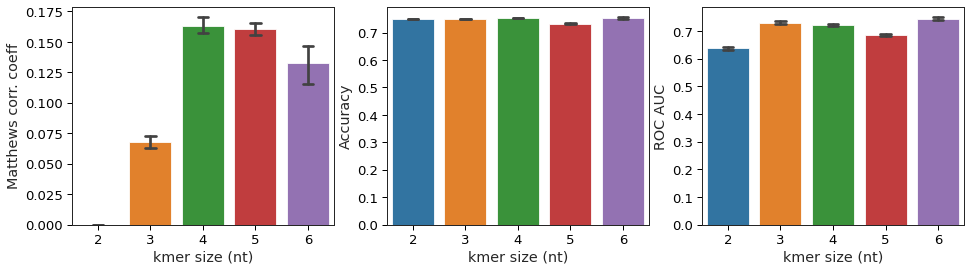

In [7]:
# look at model performance on test set 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'test mcc', data = df_mnb_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'test accuracy', data = df_mnb_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'test roc_auc', data = df_mnb_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

Text(0, 0.5, 'ROC AUC')

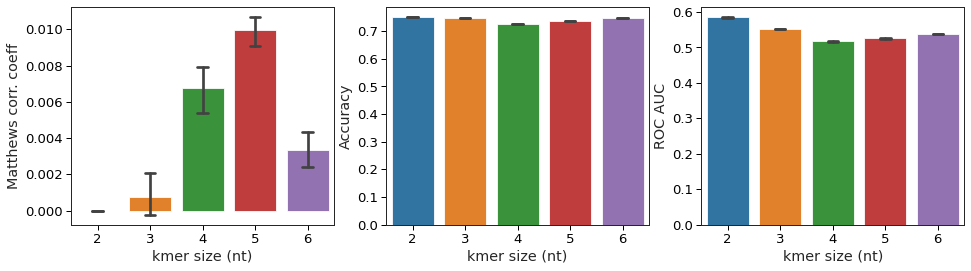

In [8]:
# look at model performance on scrambled sequences 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'scrambled mcc', data = df_mnb_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'scrambled accuracy', data = df_mnb_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'scrambled roc_auc', data = df_mnb_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

In [ ]:
# to be consistent with language model performance, we will use a 3-mer 

# train a NB model with a kmer-size of 3 and get the best model
model = MultinomialNB()
model_params = {
    'alpha':np.linspace(0.0,1.0,20),
    'fit_prior': [True]
}

_, clf_best_nb = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = 3, 
                                        ngram_stride = 3, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)

In [ ]:
# plot the learning curve for the corresponding model and the test-scores are returned for each function
tsm_nb, tsd_nb = get_model_lc(df_classify = df_classify, 
                             model = clf_best_nb, 
                             ngram_size = 3, 
                             ngram_stride = 3,
                             title = 'Naive-Bayes Tf-iDF Model')

In [ ]:
# try a logistic regression model 

model = LogisticRegression()
model_params = {
        'penalty': ["l1", "l2", "elasticnet"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10.],
        'max_iter': [100],
        'n_jobs': [-1],
        'class_weight': ["balanced"],
        'solver': ['sag']
}

ngram_sizes = np.linspace(2,6,5).astype(int)
df_lr_results = pd.DataFrame()
for ngram in ngram_sizes:
    # set both the stride and size to the same
    ngram_stride = ngram
    ngram_size = ngram
    df_eval, _ = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = ngram_size, 
                                        ngram_stride = ngram_stride, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)
    df_lr_results = pd.concat([df_lr_results, df_eval], axis = 0)

In [ ]:
# look at model performance on test set 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'test mcc', data = df_lr_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'test accuracy', data = df_lr_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'test roc_auc', data = df_lr_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

In [ ]:
# look at model performance on scrambled sequences 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'scrambled mcc', data = df_lr_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'scrambled accuracy', data = df_lr_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'scrambled roc_auc', data = df_lr_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

In [ ]:
# a logistic regression model with a kmer size of 3
model = LogisticRegression()
model_params = {
        'penalty': ["l1", "l2", "elasticnet"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10.],
        'max_iter': [10],
        'n_jobs': [-1],
        'class_weight': ["balanced"],
        'solver': ['sag']
}

_, clf_best_lr = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = 3, 
                                        ngram_stride = 3, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)

In [ ]:
# plot the learning curve for the corresponding model and the test-scores are returned for each function
tsm_lr, tsd_lr = get_model_lc(df_classify = df_classify, 
                             model = clf_best_lr, 
                             ngram_size = 3, 
                             ngram_stride = 3,
                             title = 'Logistic Regression Tf-iDF Model')

In [ ]:
# try a random-forest model 
model_params = {
        'n_estimators': [100, 200],
        'criterion': ["gini", "entropy"],
        'max_features': ["auto", "log2", None],
        'min_samples_leaf':  [2,3,4],
        'n_jobs': [-1],
        'class_weight': ["balanced"],
        'ccp_alpha': [0.01, 0.05, 0.1]
}

model = RandomForestClassifier(verbose = 0)

ngram_sizes = np.linspace(2,6,5).astype(int)

df_rf_results = pd.DataFrame()
for ngram in ngram_sizes:
    # set both the stride and size to the same
    ngram_stride = ngram
    ngram_size = ngram
    df_eval, _ = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = ngram_size, 
                                        ngram_stride = ngram_stride, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)
    df_rf_results = pd.concat([df_rf_results, df_eval], axis = 0)

In [ ]:
# look at model performance on test set 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'test mcc', data = df_rf_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'test accuracy', data = df_rf_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'test roc_auc', data = df_rf_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

In [ ]:
# look at model performance on scrambled sequences 

fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.barplot(x = 'ngram_size', y = 'scrambled mcc', data = df_rf_results, ax = axs[0], capsize = 0.2)
axs[0].set_xlabel('kmer size (nt)')
axs[0].set_ylabel('Matthews corr. coeff')

sns.barplot(x = 'ngram_size', y = 'scrambled accuracy', data = df_rf_results, ax = axs[1], capsize = 0.2)
axs[1].set_xlabel('kmer size (nt)')
axs[1].set_ylabel('Accuracy')

sns.barplot(x = 'ngram_size', y = 'scrambled roc_auc', data = df_rf_results, ax = axs[2], capsize = 0.2)
axs[2].set_xlabel('kmer size (nt)')
axs[2].set_ylabel('ROC AUC')

In [ ]:
model_params = {
        'n_estimators': [100, 200],
        'criterion': ["gini", "entropy"],
        'max_features': ["auto", "log2", None],
        'min_samples_leaf':  [2,3,4],
        'n_jobs': [-1],
        'class_weight': ["balanced"],
        'ccp_alpha': [0.01, 0.05, 0.1]
}

model = RandomForestClassifier(verbose = 0)

_, clf_best_rf = simulate_sklearn_model(df_classify = df_classify, 
                                        ngram_size = 3, 
                                        ngram_stride = 3, 
                                        model = model, 
                                        model_params = model_params, 
                                        num_trials = 5)

In [ ]:
# plot the learning curve for the corresponding model and the test-scores are returned for each function
tsm_rf, tsd_rf = get_model_lc(df_classify = df_classify, 
                             model = clf_best_rf, 
                             ngram_size = 3, 
                             ngram_stride = 3,
                             title = 'Random Forest Tf-iDF Model')